# Load data

In [1]:
%matplotlib inline

In [2]:
import numpy as np 
import sklearn 
import scipy.misc
import matplotlib.pyplot as plt

In [71]:
# loading data
x_train = np.loadtxt("data/train_x.csv", delimiter=",")
y_train = np.loadtxt("data/train_y.csv", delimiter=",")
x_test = np.loadtxt("data/test_x.csv", delimiter=",")
print("Done")

Done


In [77]:
# encode y_train data in one-hot encoding
def to_one_hot(y):
    y_train_one_hot = [[0 for i in range(10)] for i in range(len(y))]
    for i in range(len(y)):
        y_train_one_hot[i][int(y[i])] = 1

    return np.array(y_train_one_hot)

def from_one_hot(one_hot_data):
    y = []
    for row in one_hot_data:
        y.append(np.argmax(row))

    return y

In [19]:
def show_img(img):
    plt.close()
    plt.imshow(img, cmap='gray_r')
    plt.show()

x_train_reshaped = x_train.reshape(-1, 64, 64)
y_train_reshaped = y_train.reshape(-1, 1) 
x_test_reshaped = x_test.reshape(-1, 64, 64)


In [5]:
def clean_data(x):
    """
    Because the only thing that matters is the numbers in the picture, which are black, 
    we recode the pixels as 1 if the pixel was 255 and 0 otherwise. To reduce noise and to
    reduce overflow/underflow in later stages.
    """
    new_data = []
    for row in x:
        new_row = []
        for pixel in row:
            if pixel == 255:
                new_row.append(1)
            else:
                new_row.append(0)
        new_data.append(new_row)
    return np.array(new_data)



## Split training data into train / valid sets

In [73]:
from sklearn.model_selection import train_test_split
x_train_s, x_valid_s, y_train_s, y_valid_s = train_test_split(x_train, y_train, train_size=0.8, test_size=0.2)
data = {
    "x_train": clean_data(x_train_s),
    "x_valid": clean_data(x_valid_s),
    "y_train": to_one_hot(y_train_s),
    "y_valid": to_one_hot(y_valid_s),
    "y_train_og": y_train_s,
    "y_valid_og": y_valid_s,
}

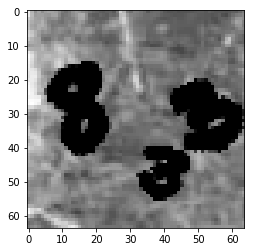

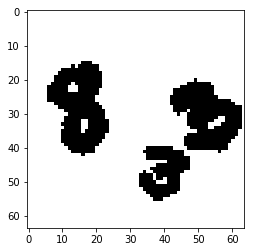

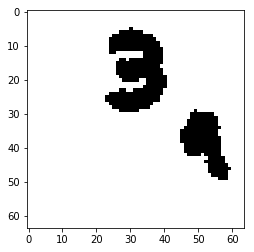

In [22]:
# x_cleaned_reshaped = data["x_train"].reshape(-1, 64, 64)

# x_train_s_reshaped = x_train_s.reshape(-1, 64, 64)
# show_img(x_train_s_reshaped[0])
# show_img(x_cleaned_reshaped[0])
# x_v_cleaned_reshaped = data["x_valid"].reshape(-1, 64, 64)
# show_img(x_v_cleaned_reshaped[0])

# Baseline Linear Classifier: Linear SVM

In [23]:
from sklearn import metrics
from sklearn.svm import LinearSVC

(40000, 4096)

In [25]:
def baseline_linear_svm(data):
    """
    Using out-of-the-box linear SVM to classify data
    """
    clf = LinearSVC()
    
    y_pred = clf.fit(data["x_train"], data["y_train"]).predict(data["x_valid"])
    print(y_pred)
    return metrics.accuracy_score(data["y_valid"], y_pred, average="macro"), y_pred
    
# score, y_pred = baseline_linear_svm(data)
# print(score)

# Neural Network

In [26]:
from scipy.special import expit

In [118]:
def sigmoid(x):
    """
    sigmoid function
    """
    return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
    """
    derivative of sigmoid
    """
    return x * (1. - x)

def tanh(x):
    """
    tanh function
    """
    return np.tanh(x)

def d_tanh(x):
    """
    derivative of tanh
    """
    return 1 - x*x

def relu(x):
    """
    relu function
    """
    return np.log(1 + np.exp(x))

def d_relu(x):
    """
    derivative of relu
    """
    return np.exp(x) / 1. + np.exp(x)

def softmax(x):
    """
    softmax classifier
    40k x 10
    """
    e = np.exp(x)
    e_sum = np.sum(e, axis=1)
    y = []
    for i in range(len(e)):
        y.append(e[i]/e_sum[i])
    return np.array(y)

def d_softmax(output, y):
    """
    d loss / d output
    """
    return output - y

def log_loss(output):
    loss = []
    for i in range(len(output)):
        log_loss_sum = []
        for j in range(10):
            log_loss_sum.append(np.log(output[i][j]))
        loss.append(log_loss_sum)
    return np.array(loss)
        


In [ ]:
class Layer:
    def __init__(self, input_rows, input_cols, learning_rate=0.01, num_nodes=200, activation_func="sigmoid"):
        self.input_rows = input_rows
        self.input_cols = input_cols
        self.num_nodes = num_nodes
        self.next = None
        self.prev = None
        input_range = 1.0 / input_rows ** (1/2)
        self.w = np.random.normal(loc=0, scale=input_range, size=(self.input_cols,num_nodes))
        self.learning_rate = learning_rate
        
        if activation_func == "sigmoid":
            self.activation_func = expit
            self.d_activation_func = self.d_sigmoid
            
        else:
            pass
        
    def feedforward(self, x):
        """
        return the predictions (represented by a probability)
        """
        # calculate stuff
        self.input = x
        before_activation = np.dot(x, self.w)
        self.output = self.activation_func(before_activation) 
        self.derivative = self.d_activation_func(before_activation)
        
        
        
        # if there's a next layer
        if self.next:
            passed_output = []
            # add bias to the end of each row of self.output
            try:
                passed_output = np.append(self.output, np.ones((self.output.shape[0], 1)), axis=-1)
            except ValueError:
                passed_output = np.append(self.output, 1) 
            
            # call next layer's feedforward step
            self.next.feedforward(passed_output)

        
    def backprop(self, prev_deltas):
        """
        compute derivatives and adjust w
        """ 
#         deltas = np.dot(self.derivative, prev_deltas )
        deltas = prev_deltas * self.derivative
        if self.prev:
            self.prev.backprop(np.dot(self.w[:-1], deltas))
        self.w = self.w - (self.learning_rate * np.dot(self.input.T, deltas))
    
        
    def sigmoid(self, x):
        """
        sigmoid function
        """
        return 1 / (1 + np.exp(-x))

    def d_sigmoid(self, x):
        """
        derivative of sigmoid
        """
        return x * (1. - x)
   
    
class OutputLayer(Layer):
    def __init__(self, input_rows, input_cols, learning_rate=0.01, num_nodes=200, activation_func="softmax"):
        self.input_rows = input_rows
        self.input_cols = input_cols
        self.num_nodes = num_nodes
        self.next = None
        self.prev = None
        input_range = 1.0 / input_rows ** (1/2)
        self.w = np.random.normal(loc=0, scale=input_range, size=(self.input_cols,num_nodes))
        self.learning_rate = learning_rate
        
        if activation_func == "softmax":
            self.activation_func = self.softmax
            self.backprop_func = lambda x, target: x - target
            
        elif activation_func == "sigmoid":
            self.activation_func = self.sigmoid
            self.backprop_func = lambda x, target: self.d_sigmoid(x) * (x - target)
            
        else:
            pass
        
        # Value is unused.
        self.d_activation_func = lambda x: None
     
    def backprop(self, targets):
        deltas = self.backprop_func(self.output, targets)
        self.prev.backprop(np.dot(self.w[:-1], deltas.T).T)
        self.w = self.w - self.learning_rate * np.dot(self.input.T, deltas)
        
    
    def softmax(self, x):
#         e = np.exp(x - np.amax(x))
#         dist = e / np.sum(e)
#         return dist
#         e = np.exp(x-np.amax(x))
#         e_sum = np.sum(e, axis=1)
        y = []
        for i in range(len(x)):
            row_exp = np.exp(x[i] - np.amax(x[i]))
            row_sum = np.sum(row_exp)
            y.append(row_exp/row_sum)
        return np.array(y)
        
    
class NeuralNet:
    def __init__(self, learning_rate, num_epochs):
        self.first = None
        self.last = None
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        
    def add_layer(self, layer):
        """
        Add layer to the end
        """
        if not self.first:
            self.first = layer
            self.last = layer
            
        else:
            temp = self.last
            temp.next = layer
            layer.prev = temp
            self.last = layer
            
    def fit(self, x_train, y_train):
        x_input = np.append(x_train, np.ones((x_train.shape[0], 1)), axis=-1)
        
        for i in range(self.num_epochs):

#             print(i, "before feedforward & backprop")
#             print(self.first.w)
#             print(self.first.next.w)
#             print(self.last.w)
            for j in range(0, len(x_input), 1000):
                self.first.feedforward(x_input[j:j+1000])
                self.last.backprop(y_train[j:j+1000])
                
#             print(i, "after feedforward & backprop")
#             print(self.first.w)
#             print(self.first.next.w)
#             print(self.last.w)
            if i%10 == 0:
                print(i, "after feedforward & backprop")
                print(self.get_accuracy())
                
                
    def predict(self, x):
        x_input = np.append(x, np.ones((x.shape[0], 1)), axis=-1)
        self.first.feedforward(x_input)
        return self.last.output
    
    def get_accuracy(self):
        y_pred = self.predict(data["x_valid"])
        return metrics.accuracy_score(data["y_valid_og"], from_one_hot(y_pred))


x_tr = data["x_train"]
y_tr = data["y_train"]

neural_net = NeuralNet(1e-5, 11)

neural_net.add_layer(Layer(x_tr.shape[0], x_tr.shape[1] + 1, 1e-5, 300))
# neural_net.add_layer(Layer(x_tr.shape[0], 300 + 1, 1e-6, 200))
neural_net.add_layer(OutputLayer(x_tr.shape[0], 300 + 1, 1e-5, 10))

neural_net.fit(x_tr, y_tr)
predict_y = neural_net.predict(data["x_valid"])
print("Done")
        
        
        

0 after feedforward & backprop
0.1102


In [91]:

print(np.dot(neural_net.first.input, neural_net.first.w))
print(neural_net.first.w)
# print("\nfirst layer before activation")
# print(np.dot(neural_net.first.input, neural_net.first.w))
# print("\noutput of first layer")
# print(neural_net.first.output)
# print("\nsecond layer inputs")
# print(neural_net.first.next.input)
# print(neural_net.first.next.output)
# print(neural_net.last.input)
# product_output = np.dot(neural_net.last.input, neural_net.last.w)
# print(softmax(product_output))
# print(predict_y[:10])
# print(data["y_valid"][:10])
# print(metrics.accuracy_score(data["y_valid_og"], from_one_hot(predict_y)))

[[ -3.32170962e-02   8.91498498e-02  -8.19796164e-02 ...,   2.27671944e-02
   -1.67657537e-01  -1.91276228e-02]
 [  2.06230481e-02   1.60014401e-01  -7.50685090e-02 ...,   3.13939483e-01
   -1.23864409e-01   9.12691473e-03]
 [ -1.43118609e-01  -5.23414343e-02  -2.07804312e-01 ...,   1.92564699e-01
    1.03645713e-01   1.28003648e-01]
 ..., 
 [  4.73107047e-02   1.26375543e-02  -3.10501088e-01 ...,   3.02129856e-02
   -1.59127307e-01   1.59452056e-04]
 [  2.85233288e-01   1.91259839e-01  -1.40927490e-01 ...,   6.55229381e-02
   -7.74582496e-03  -1.02979344e-01]
 [  1.09062927e-01   6.28601422e-02  -7.16873426e-02 ...,  -2.83865329e-02
   -1.93778901e-01   3.86722218e-02]]
[[-0.00074778 -0.0056412   0.00764514 ..., -0.00425466 -0.00023273
   0.00353539]
 [ 0.00214177  0.00537554 -0.00394161 ...,  0.00412829  0.00033678
   0.00088118]
 [ 0.00409851  0.00665253 -0.00112159 ..., -0.00095702 -0.00508079
   0.00286436]
 ..., 
 [-0.00208292 -0.00200593 -0.00057557 ..., -0.00263905  0.00360843
